In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Common packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from scipy.stats import uniform, randint

# Sklearn for ML
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

# Custom packages
os.chdir("C:/Users/Titouan/Documents/HepavirAlgo")
pd.set_option("display.max_columns", None)
import funcsnds.predstatus as ps
import funcsnds.globalvar as gv

In [3]:
path_snds = "D:/Data/HEPAT_VUE_30012023/HEP_CSV/"
snds_hepather = pd.read_csv("data/chainage_snds_statut_hepather.csv").drop_duplicates()

# Création du dataset

In [4]:
cat_target = "fibrose_F4_B"

affine_used = {
    "DCIR" : ["ER_BIO_F", "ER_CAM_F", "ER_PHA_F", "ER_UCD_F"],
    "MCO"  : ["A", "D", "UM", "FL", "FM"],
    "SSR"  : ["D"]
}

curated_vars = None
# Si on voulait choisir les variables à la main
#curated_vars = gv.fibrose_f4_b_curated
how_many_vars = 10

In [5]:
# # Creation du dataset, à réaliser une fois, sauf si on change les variables
# range_year = range(12,22)
# _ = ps.create_snds_allyear_allnumenq(range_year, affine_used, how_many_vars, curated_vars, cat_target, path_snds)

In [6]:
# Moyennisation des données sur 3 ans
type_agreg = "mean"
df_final, var_predict = ps.create_dateset_threeyears(type_agreg, snds_hepather, affine_used, how_many_vars, curated_vars, cat_target, path_snds)

# Si on voulait garder une seule année
#df_final, var_predict = ps.create_dateset_oneyear(snds_hepather, affine_used, how_many_vars, curated_vars, cat_target, path_snds)

In [8]:
# Permet de se rendre compte si des variables sont "largement distribuées" ce qui pourrait ralentir le processus sur le portail CNAM
for column_name in df_final.columns:
    column = df_final[column_name]
    perc = np.round(100*(column == 0).sum()/len(column),1)
    print("Perc in", column_name, " is : ", perc)

Perc in NUM_ENQ  is :  0.0
Perc in BIO_PRS_IDE/1000  is :  97.7
Perc in BIO_PRS_IDE/1015  is :  94.9
Perc in BIO_PRS_IDE/1104  is :  14.9
Perc in BIO_PRS_IDE/1133  is :  91.7
Perc in BIO_PRS_IDE/1213  is :  62.1
Perc in BIO_PRS_IDE/126  is :  49.2
Perc in BIO_PRS_IDE/1577  is :  77.2
Perc in BIO_PRS_IDE/1609  is :  38.6
Perc in BIO_PRS_IDE/1740  is :  88.1
Perc in BIO_PRS_IDE/1804  is :  48.0
Perc in BIO_PRS_IDE/1806  is :  70.7
Perc in BIO_PRS_IDE/320  is :  55.0
Perc in BIO_PRS_IDE/388  is :  72.0
Perc in BIO_PRS_IDE/4120  is :  24.5
Perc in BIO_PRS_IDE/522  is :  12.1
Perc in BIO_PRS_IDE/578  is :  66.2
Perc in BIO_PRS_IDE/592  is :  36.5
Perc in BIO_PRS_IDE/7318  is :  83.3
Perc in BIO_PRS_IDE/7402  is :  89.4
Perc in BIO_PRS_IDE/9926  is :  88.1
Perc in CAM_PRS_IDE/BZQK001  is :  94.7
Perc in CAM_PRS_IDE/DEQP003  is :  83.4
Perc in CAM_PRS_IDE/DZQM006  is :  86.7
Perc in CAM_PRS_IDE/HBJD001  is :  71.5
Perc in CAM_PRS_IDE/HBQK002  is :  82.7
Perc in CAM_PRS_IDE/HEQE002  is :  95.2

In [9]:
# # En utilisant le split de sklearn
# X_train, X_test, y_train, y_test = train_test_split(df_final[var_predict], df_final[cat_target], test_size = 0.3)
# dtrain = xgb.DMatrix(X_train, label = y_train)
# dtest = xgb.DMatrix(X_test, label = y_test)

# Custom function pour resampler et "balanced" dans l'échantillon d'entraînement
# Le seed n'est pas figé à dessein, pour ne pas "overfitter le seed"
#X_cv, y_cv, X_test, y_test, num_enq_train = ps.prepare_data(cat_target, var_predict, df_final, size_train = 0.8)

X_cv, X_test, y_cv, y_test = train_test_split(df_final[var_predict], df_final[cat_target], test_size = 0.2)
num_enq_train = list(df_final.iloc[X_cv.index]["NUM_ENQ"])
num_enq_test = list(df_final.iloc[X_test.index]["NUM_ENQ"])
spw = (len(y_cv) - y_cv.sum())/y_cv.sum()
print(f"Le déséquilibre dans l'échantillon d'entraînement est de {np.round(spw, 1)} fois plus de négatifs que positifs")

Le déséquilibre dans l'échantillon d'entraînement est de 9.6 fois plus de négatifs que positifs


# Entraînement régression Logisitique

En raison de problèmes d'importation des modèles XGBoost au format `.json` sur la plateforme CNAM, un modèle linéaire a été estimé

In [10]:
%%time

## Random search XGB

model_simple = LogisticRegression(class_weight=spw, max_iter = 2000)

param_distrib_log = {
    "C" : uniform(0.1, 2)
}

clf_log = RandomizedSearchCV(
    model_simple, 
    param_distributions = param_distrib_log,
    scoring = "balanced_accuracy", 
    n_iter = 50, cv = 4, 
    n_jobs = 1,
    verbose = 10,
    return_train_score = True
)

clf_log.fit(X_cv, y_cv)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START C=1.8230062540457663.......................................
[CV 1/4; 1/50] END C=1.8230062540457663;, score=(train=0.732, test=0.711) total time=   0.2s
[CV 2/4; 1/50] START C=1.8230062540457663.......................................
[CV 2/4; 1/50] END C=1.8230062540457663;, score=(train=0.736, test=0.702) total time=   0.2s
[CV 3/4; 1/50] START C=1.8230062540457663.......................................
[CV 3/4; 1/50] END C=1.8230062540457663;, score=(train=0.757, test=0.630) total time=   0.1s
[CV 4/4; 1/50] START C=1.8230062540457663.......................................
[CV 4/4; 1/50] END C=1.8230062540457663;, score=(train=0.747, test=0.700) total time=   0.2s
[CV 1/4; 2/50] START C=1.0964948376044779.......................................
[CV 1/4; 2/50] END C=1.0964948376044779;, score=(train=0.723, test=0.696) total time=   0.1s
[CV 2/4; 2/50] START C=1.0964948376044779...........................

[CV 4/4; 12/50] END C=1.602280618830832;, score=(train=0.739, test=0.700) total time=   0.2s
[CV 1/4; 13/50] START C=0.372446282221531.......................................
[CV 1/4; 13/50] END C=0.372446282221531;, score=(train=0.705, test=0.690) total time=   0.0s
[CV 2/4; 13/50] START C=0.372446282221531.......................................
[CV 2/4; 13/50] END C=0.372446282221531;, score=(train=0.703, test=0.676) total time=   0.1s
[CV 3/4; 13/50] START C=0.372446282221531.......................................
[CV 3/4; 13/50] END C=0.372446282221531;, score=(train=0.727, test=0.615) total time=   0.0s
[CV 4/4; 13/50] START C=0.372446282221531.......................................
[CV 4/4; 13/50] END C=0.372446282221531;, score=(train=0.711, test=0.695) total time=   0.0s
[CV 1/4; 14/50] START C=0.5264239516039163......................................
[CV 1/4; 14/50] END C=0.5264239516039163;, score=(train=0.711, test=0.690) total time=   0.1s
[CV 2/4; 14/50] START C=0.5264239516

[CV 4/4; 24/50] END C=1.425460595874966;, score=(train=0.742, test=0.700) total time=   0.2s
[CV 1/4; 25/50] START C=1.5531284529646132......................................
[CV 1/4; 25/50] END C=1.5531284529646132;, score=(train=0.731, test=0.696) total time=   0.2s
[CV 2/4; 25/50] START C=1.5531284529646132......................................
[CV 2/4; 25/50] END C=1.5531284529646132;, score=(train=0.729, test=0.695) total time=   0.1s
[CV 3/4; 25/50] START C=1.5531284529646132......................................
[CV 3/4; 25/50] END C=1.5531284529646132;, score=(train=0.755, test=0.630) total time=   0.1s
[CV 4/4; 25/50] START C=1.5531284529646132......................................
[CV 4/4; 25/50] END C=1.5531284529646132;, score=(train=0.739, test=0.700) total time=   0.2s
[CV 1/4; 26/50] START C=1.8031900743844627......................................
[CV 1/4; 26/50] END C=1.8031900743844627;, score=(train=0.732, test=0.703) total time=   0.2s
[CV 2/4; 26/50] START C=1.803190

[CV 4/4; 36/50] END C=1.9246619943479535;, score=(train=0.749, test=0.699) total time=   0.2s
[CV 1/4; 37/50] START C=1.887002640730243.......................................
[CV 1/4; 37/50] END C=1.887002640730243;, score=(train=0.732, test=0.711) total time=   0.2s
[CV 2/4; 37/50] START C=1.887002640730243.......................................
[CV 2/4; 37/50] END C=1.887002640730243;, score=(train=0.736, test=0.702) total time=   0.2s
[CV 3/4; 37/50] START C=1.887002640730243.......................................
[CV 3/4; 37/50] END C=1.887002640730243;, score=(train=0.757, test=0.630) total time=   0.1s
[CV 4/4; 37/50] START C=1.887002640730243.......................................
[CV 4/4; 37/50] END C=1.887002640730243;, score=(train=0.747, test=0.699) total time=   0.1s
[CV 1/4; 38/50] START C=1.597468212131268.......................................
[CV 1/4; 38/50] END C=1.597468212131268;, score=(train=0.731, test=0.696) total time=   0.1s
[CV 2/4; 38/50] START C=1.5974682121

[CV 4/4; 48/50] END C=1.075825919376684;, score=(train=0.729, test=0.700) total time=   0.1s
[CV 1/4; 49/50] START C=2.0171792981974708......................................
[CV 1/4; 49/50] END C=2.0171792981974708;, score=(train=0.732, test=0.710) total time=   0.2s
[CV 2/4; 49/50] START C=2.0171792981974708......................................
[CV 2/4; 49/50] END C=2.0171792981974708;, score=(train=0.736, test=0.702) total time=   0.2s
[CV 3/4; 49/50] START C=2.0171792981974708......................................
[CV 3/4; 49/50] END C=2.0171792981974708;, score=(train=0.760, test=0.630) total time=   0.1s
[CV 4/4; 49/50] START C=2.0171792981974708......................................
[CV 4/4; 49/50] END C=2.0171792981974708;, score=(train=0.749, test=0.699) total time=   0.2s
[CV 1/4; 50/50] START C=1.1937853824968199......................................
[CV 1/4; 50/50] END C=1.1937853824968199;, score=(train=0.723, test=0.696) total time=   0.1s
[CV 2/4; 50/50] START C=1.193785

RandomizedSearchCV(cv=4,
                   estimator=LogisticRegression(class_weight=9.555984555984557,
                                                max_iter=2000),
                   n_iter=50, n_jobs=1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002AB44F9D130>},
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=10)

In [11]:
log_chosen = clf_log.best_estimator_

clf_log.best_params_

{'C': 1.8230062540457663}

In [12]:
predictions_score = clf_log.predict_proba(X_test)[:,1]

In [13]:
predictions = clf_log.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       608
         1.0       0.80      0.43      0.56        76

    accuracy                           0.93       684
   macro avg       0.87      0.71      0.76       684
weighted avg       0.92      0.93      0.92       684



In [14]:
predictions = clf_log.predict(X_cv)
print(classification_report(y_cv, predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2475
         1.0       0.85      0.45      0.59       259

    accuracy                           0.94      2734
   macro avg       0.90      0.72      0.78      2734
weighted avg       0.94      0.94      0.93      2734



In [15]:
clf_log.best_estimator_.intercept_

array([-3.57116243])

In [16]:
coef_model_log = pd.DataFrame([("CONSTANTE", + clf_log.best_estimator_.intercept_[0])] + list(zip(clf_log.feature_names_in_, clf_log.best_estimator_.coef_[0])), columns = ["Var", "Coef"])

In [17]:
metrics_curve_log = []
for threshold in range(1,100):
    predictions_threshold = (predictions_score >= (threshold/100))
    class_report = classification_report(y_test, predictions_threshold, output_dict = True)
    row = [threshold/100, 
       np.round(100*class_report["1.0"]["precision"], 1), 
       np.round(100*class_report["1.0"]["recall"], 1),
       np.round(100*class_report["0.0"]["precision"], 1),
       np.round(100*class_report["0.0"]["recall"], 1)]
    metrics_curve_log.append(row)
    
metrics_curve_log_df = pd.DataFrame(metrics_curve_log, columns = ("Seuil", "Precision", "Sensibilite", "Prec_neg", "Specificite"))

In [18]:
metrics_curve_log_df

Seuil  Precision  Sensibilite  Prec_neg  Specificite
0    0.01       12.0         93.4      94.5         14.1
1    0.02       14.6         89.5      96.3         34.7
2    0.03       19.4         88.2      97.3         54.3
3    0.04       23.8         85.5      97.3         65.8
4    0.05       29.2         84.2      97.4         74.5
..    ...        ...          ...       ...          ...
94   0.95       85.0         22.4      91.1         99.5
95   0.96       83.3         19.7      90.8         99.5
96   0.97       83.3         19.7      90.8         99.5
97   0.98       82.4         18.4      90.7         99.5
98   0.99       76.9         13.2      90.2         99.5

[99 rows x 5 columns]

In [19]:
if curated_vars == None :
    dump(clf_log, "results/" + cat_target + "/model_cv_log.joblib")
    coef_model_log.to_csv("results/" + cat_target + "/coef_model_log.csv", sep = ";", index = False)
    metrics_curve_log_df.to_csv("results/" + cat_target + "/metrics_curve_log.csv", sep = ";", index = False)
else:
    dump(clf_log, "results/" + cat_target + "/model_cv_log_curated.joblib")
    coef_model_log.to_csv("results/" + cat_target + "/coef_model_log_curated.csv", sep = ";", index = False)
    metrics_curve_log_df.to_csv("results/" + cat_target + "/metrics_curve__logcurated.csv", sep = ";", index = False)

In [20]:
final = pd.DataFrame(list(zip(y_test, predictions, predictions_score)), columns = ["True", "Pred", "Score"])

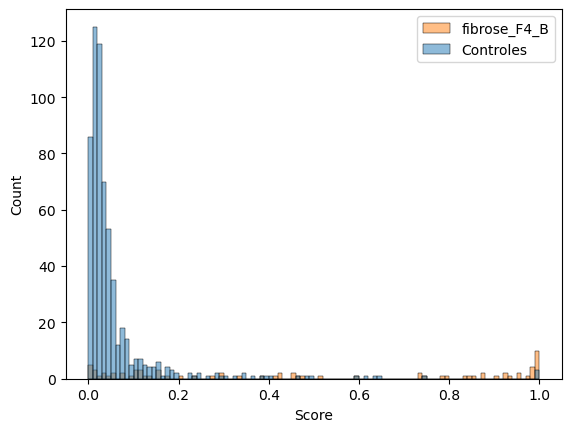

In [21]:
sns.histplot(data = final, x = "Score", hue = "True", bins = 100)
_ = plt.legend(labels = [cat_target, "Controles"])

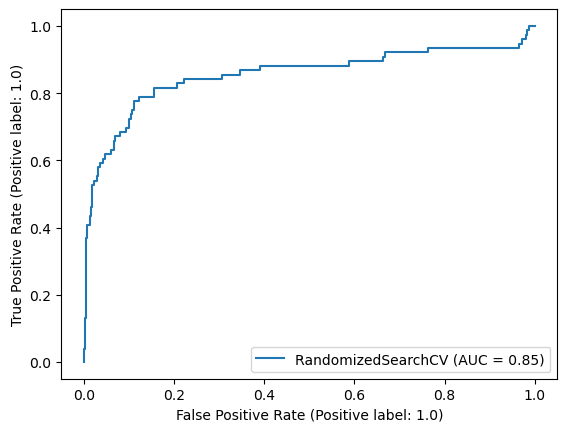

In [22]:
_ = RocCurveDisplay.from_estimator(clf_log, X_test, y_test)

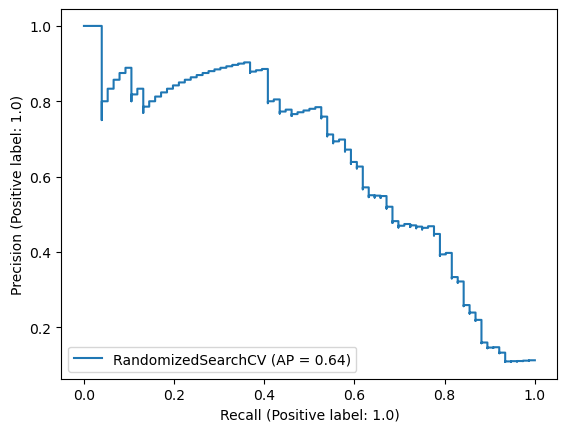

In [23]:
_ = PrecisionRecallDisplay.from_estimator(clf_log, X_test, y_test)

# Entraînement du XGBoost

In [24]:
## Recherche infructueuse avec plus de paramètres à parcourir

# %%time

# ## Random search XGB

# xgb_model = xgb.XGBClassifier()

# param_distrib_XGB = {
#     "n_estimators" : randint(50, 500),
#     "max_depth" : randint(2, 20),
#     "min_child_weight" : randint(1, 5),
#     "learning_rate" : uniform(0.01,1),
#     "gamma" : randint(0, 10)
# }

# clf = RandomizedSearchCV(
#     xgb_model, 
#     param_distributions = param_distrib_XGB,
#     scoring = "accuracy", 
#     n_iter = 200, cv = 4, 
#     n_jobs = 1,
#     verbose = 10
#     #random_state = 42
# )

# clf.fit(X_cv, y_cv)

In [25]:
%%time

## Random search XGB

xgb_model = xgb.XGBClassifier(scale_pos_weight = spw)

param_distrib_XGB = {
    "n_estimators" : randint(200, 300),
    "max_depth" : randint(1, 6),
}

clf = RandomizedSearchCV(
    xgb_model, 
    param_distributions = param_distrib_XGB,
    scoring = "balanced_accuracy", 
    n_iter = 50, cv = 4, 
    n_jobs = 1,
    verbose = 10,
    return_train_score = True
)

clf.fit(X_cv, y_cv)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START max_depth=1, n_estimators=217..............................
[CV 1/4; 1/50] END max_depth=1, n_estimators=217;, score=(train=0.893, test=0.760) total time=   0.4s
[CV 2/4; 1/50] START max_depth=1, n_estimators=217..............................
[CV 2/4; 1/50] END max_depth=1, n_estimators=217;, score=(train=0.876, test=0.804) total time=   0.3s
[CV 3/4; 1/50] START max_depth=1, n_estimators=217..............................
[CV 3/4; 1/50] END max_depth=1, n_estimators=217;, score=(train=0.900, test=0.696) total time=   0.3s
[CV 4/4; 1/50] START max_depth=1, n_estimators=217..............................
[CV 4/4; 1/50] END max_depth=1, n_estimators=217;, score=(train=0.887, test=0.781) total time=   0.4s
[CV 1/4; 2/50] START max_depth=4, n_estimators=224..............................
[CV 1/4; 2/50] END max_depth=4, n_estimators=224;, score=(train=1.000, test=0.732) total time=   0.5s
[CV 2/4; 2/50] START ma

[CV 1/4; 12/50] END max_depth=4, n_estimators=271;, score=(train=1.000, test=0.739) total time=   0.7s
[CV 2/4; 12/50] START max_depth=4, n_estimators=271.............................
[CV 2/4; 12/50] END max_depth=4, n_estimators=271;, score=(train=0.997, test=0.722) total time=   0.7s
[CV 3/4; 12/50] START max_depth=4, n_estimators=271.............................
[CV 3/4; 12/50] END max_depth=4, n_estimators=271;, score=(train=0.997, test=0.665) total time=   0.7s
[CV 4/4; 12/50] START max_depth=4, n_estimators=271.............................
[CV 4/4; 12/50] END max_depth=4, n_estimators=271;, score=(train=0.997, test=0.685) total time=   0.7s
[CV 1/4; 13/50] START max_depth=5, n_estimators=211.............................
[CV 1/4; 13/50] END max_depth=5, n_estimators=211;, score=(train=1.000, test=0.726) total time=   0.6s
[CV 2/4; 13/50] START max_depth=5, n_estimators=211.............................
[CV 2/4; 13/50] END max_depth=5, n_estimators=211;, score=(train=0.997, test=0.7

[CV 2/4; 23/50] END max_depth=2, n_estimators=281;, score=(train=0.981, test=0.779) total time=   0.6s
[CV 3/4; 23/50] START max_depth=2, n_estimators=281.............................
[CV 3/4; 23/50] END max_depth=2, n_estimators=281;, score=(train=0.978, test=0.688) total time=   0.6s
[CV 4/4; 23/50] START max_depth=2, n_estimators=281.............................
[CV 4/4; 23/50] END max_depth=2, n_estimators=281;, score=(train=0.983, test=0.717) total time=   0.6s
[CV 1/4; 24/50] START max_depth=2, n_estimators=262.............................
[CV 1/4; 24/50] END max_depth=2, n_estimators=262;, score=(train=0.982, test=0.731) total time=   0.5s
[CV 2/4; 24/50] START max_depth=2, n_estimators=262.............................
[CV 2/4; 24/50] END max_depth=2, n_estimators=262;, score=(train=0.973, test=0.786) total time=   0.6s
[CV 3/4; 24/50] START max_depth=2, n_estimators=262.............................
[CV 3/4; 24/50] END max_depth=2, n_estimators=262;, score=(train=0.975, test=0.6

[CV 3/4; 34/50] END max_depth=5, n_estimators=222;, score=(train=0.997, test=0.641) total time=   0.6s
[CV 4/4; 34/50] START max_depth=5, n_estimators=222.............................
[CV 4/4; 34/50] END max_depth=5, n_estimators=222;, score=(train=0.997, test=0.689) total time=   0.6s
[CV 1/4; 35/50] START max_depth=3, n_estimators=240.............................
[CV 1/4; 35/50] END max_depth=3, n_estimators=240;, score=(train=0.997, test=0.745) total time=   0.6s
[CV 2/4; 35/50] START max_depth=3, n_estimators=240.............................
[CV 2/4; 35/50] END max_depth=3, n_estimators=240;, score=(train=0.994, test=0.753) total time=   0.6s
[CV 3/4; 35/50] START max_depth=3, n_estimators=240.............................
[CV 3/4; 35/50] END max_depth=3, n_estimators=240;, score=(train=0.997, test=0.677) total time=   0.6s
[CV 4/4; 35/50] START max_depth=3, n_estimators=240.............................
[CV 4/4; 35/50] END max_depth=3, n_estimators=240;, score=(train=0.994, test=0.6

[CV 4/4; 45/50] END max_depth=1, n_estimators=282;, score=(train=0.895, test=0.771) total time=   0.5s
[CV 1/4; 46/50] START max_depth=5, n_estimators=275.............................
[CV 1/4; 46/50] END max_depth=5, n_estimators=275;, score=(train=1.000, test=0.726) total time=   0.8s
[CV 2/4; 46/50] START max_depth=5, n_estimators=275.............................
[CV 2/4; 46/50] END max_depth=5, n_estimators=275;, score=(train=0.997, test=0.696) total time=   0.8s
[CV 3/4; 46/50] START max_depth=5, n_estimators=275.............................
[CV 3/4; 46/50] END max_depth=5, n_estimators=275;, score=(train=0.997, test=0.642) total time=   0.8s
[CV 4/4; 46/50] START max_depth=5, n_estimators=275.............................
[CV 4/4; 46/50] END max_depth=5, n_estimators=275;, score=(train=0.997, test=0.689) total time=   0.8s
[CV 1/4; 47/50] START max_depth=1, n_estimators=212.............................
[CV 1/4; 47/50] END max_depth=1, n_estimators=212;, score=(train=0.891, test=0.7

RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                            

In [26]:
xgb_chosen = clf.best_estimator_.get_booster()

clf.best_params_

{'max_depth': 1, 'n_estimators': 206}

In [27]:
# BEST_PARAMS = {'max_depth': 4, 'n_estimators': 213}

# clf = xgb.XGBClassifier(**BEST_PARAMS)

# clf.fit(X_cv, y_cv)

In [28]:
predictions_score = clf.predict_proba(X_test)[:,1]

In [29]:
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       608
         1.0       0.49      0.79      0.60        76

    accuracy                           0.88       684
   macro avg       0.73      0.84      0.77       684
weighted avg       0.92      0.88      0.90       684



In [30]:
predictions_cv = clf.predict(X_cv)
print(classification_report(y_cv, predictions_cv))

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.94      2475
         1.0       0.45      0.86      0.59       259

    accuracy                           0.89      2734
   macro avg       0.72      0.88      0.76      2734
weighted avg       0.93      0.89      0.90      2734



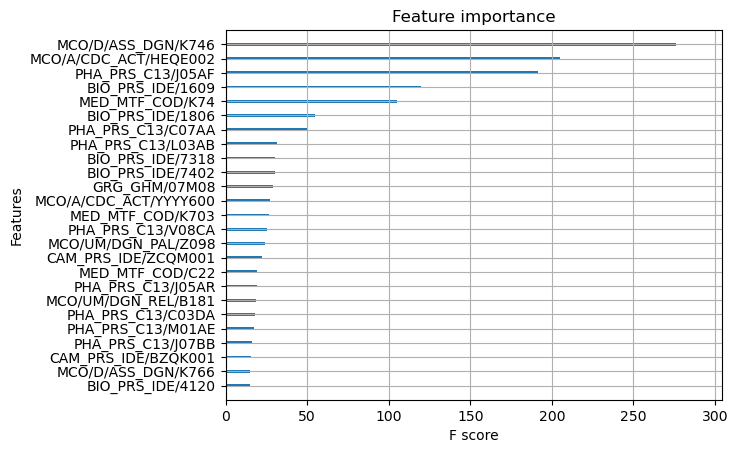

In [31]:
_ = xgb.plot_importance(clf.best_estimator_, 
                        importance_type = "gain",
                        max_num_features = 25,
                        show_values = False)

In [32]:
final = pd.DataFrame(list(zip(y_test, predictions, predictions_score)), columns = ["True", "Pred", "Score"])

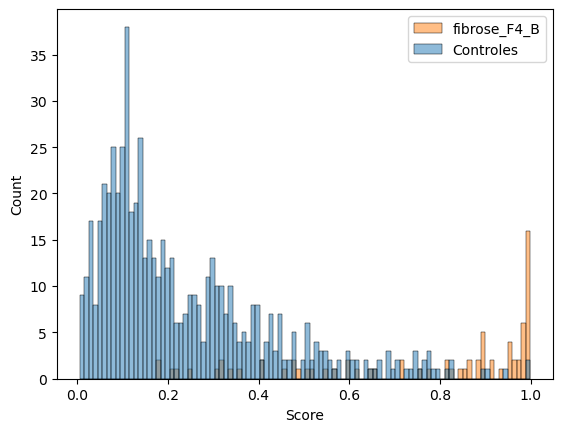

In [33]:
sns.histplot(data = final, x = "Score", hue = "True", bins = 100)
_ = plt.legend(labels = [cat_target, "Controles"])

In [34]:
metrics_curve = []
for threshold in range(1,100):
    predictions_threshold = (predictions_score >= (threshold/100))
    class_report = classification_report(y_test, predictions_threshold, output_dict = True)
    row = [threshold/100, 
       np.round(100*class_report["1.0"]["precision"], 1), 
       np.round(100*class_report["1.0"]["recall"], 1),
       np.round(100*class_report["0.0"]["precision"], 1),
       np.round(100*class_report["0.0"]["recall"], 1)]
    metrics_curve.append(row)

metrics_curve_df = pd.DataFrame(metrics_curve, columns = ("Seuil", "Precision", "Sensibilite", "Prec_neg", "Specificite"))

In [35]:
if curated_vars == None :
    dump(clf, "results/" + cat_target + "/model_cv.joblib")
    clf.best_estimator_.save_model("results/" + cat_target + "/model.json")
    clf.best_estimator_.save_model("results/" + cat_target + "/model.txt")
    clf.best_estimator_.save_model("results/" + cat_target + "/model.ubj")
    metrics_curve_df.to_csv("results/" + cat_target + "/metrics_curve.csv", sep = ";", index = False)
else:
    dump(clf, "results/" + cat_target + "/model_cv_curated.joblib")
    clf.best_estimator_.save_model("results/" + cat_target + "/model_curated.json")
    clf.best_estimator_.save_model("results/" + cat_target + "/model_curated.txt")
    clf.best_estimator_.save_model("results/" + cat_target + "/model_curated.ubj")
    metrics_curve_df.to_csv("results/" + cat_target + "/metrics_curve_curated.csv", sep = ";", index = False)

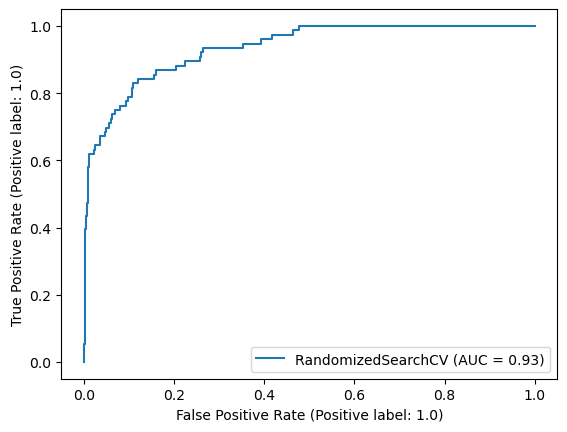

In [36]:
_ = RocCurveDisplay.from_estimator(clf, X_test, y_test)

# Si on faisait tourner l'algorithme sur plusieurs années

In [37]:
# Si au lieu de faire la moyenne sur 3 années on se limitait à une seule

# %%time
# save_score = []

# for myyear in range(12, 22):
#     print(myyear)
    
#     df_temp      = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear) + ".csv", sep = ";")
#     data_noleakage = df_temp[~df_temp["NUM_ENQ"].isin(num_enq_train)].copy()

#     X_pred, y_pred = data_noleakage[var_predict], data_noleakage[cat_target]
        
#     predictions_score = clf.predict_proba(X_pred)[:,1]
#     data_noleakage["results" + str(myyear)] = np.round(predictions_score, 2)
    
#     df_temp = data_noleakage[["NUM_ENQ", cat_target, "results" + str(myyear)]]
#     save_score.append(df_temp)
    
# df_total_score = ps.merge_years(save_score, cat_target)

In [38]:
%%time
save_score = []

for myyear in range(13, 21):
    print(myyear)
    
    df_temp_back = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear - 1) + ".csv", sep = ";")
    df_temp      = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear) + ".csv", sep = ";")
    df_temp_forw = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear + 1) + ".csv", sep = ";")
    
    df_temp = pd.concat([df_temp_back, df_temp, df_temp_forw])
    df_temp = df_temp[df_temp["NUM_ENQ"].isin(num_enq_test)]
    df_temp = df_temp.groupby("NUM_ENQ", as_index = False).mean()
    
    data_noleakage = df_temp
    
    X_pred, y_pred = data_noleakage[var_predict], data_noleakage[cat_target]
        
    predictions_score = clf.predict_proba(X_pred)[:,1]
    data_noleakage["results" + str(myyear)] = np.round(predictions_score, 2)
    
    df_temp = data_noleakage[["NUM_ENQ", cat_target, "results" + str(myyear)]]
    save_score.append(df_temp)
    
df_total_score = ps.merge_years(save_score, cat_target)

13
14
15
16
17
18
19
20
Wall time: 2.44 s


In [39]:
df_total_score = pd.merge(left = df_total_score, right = snds_hepather[["NUM_ENQ", "year_incl"]], on = "NUM_ENQ")

In [41]:
if curated_vars == None :
    df_total_score.to_csv("results/" + cat_target + "/df_score_year.csv", sep = ";", index = False)
else:
    df_total_score.to_csv("results/" + cat_target + "/df_score_year_curated.csv", sep = ";", index = False)